## The Mauna Loa CO_2 Concentration

In 1958, Charles David Keeling (1928-2005) from the Scripps Institution of Oceanography began recording carbon dioxide (CO2) concentrations in the atmosphere at an observatory located at about 3,400 m altitude on the Mauna Loa Volcano on Hawaii Island. The location was chosen because it is not influenced by changing CO2 levels due to the local vegetation and because prevailing wind patterns on this tropical island tend to bring well-mixed air to the site. While the recordings are made near a volcano (which tends to produce CO2), wind patterns tend to blow the volcanic CO2 away from the recording site. Air samples are taken several times a day, and concentrations have been observed using the same measuring method for over 60 years. In addition, samples are stored in flasks and periodically reanalyzed for calibration purposes. The observational study is now run by Ralph Keeling, Charles's son. The result is a data set with very few interruptions and very few inhomogeneities. It has been called the “most important data set in modern climate research."

The data set for this problem can be found in CO2.csv. It provides the concentration of CO2 recorded at Mauna Loa for each month starting March 1958. More description is provided in the data set file. We will be considering only the CO2 concentration given in column 5. The goal of the problem is to fit the data and understand its variations. You will encounter missing data points; part of the exercise is to deal with them appropriately.

Let 𝐶𝑖 be the average CO2 concentration in month 𝑖 (𝑖=1,2,⋯, counting from March 1958). We will look for a description of the form:

𝐶𝑖=𝐹(𝑡𝑖)+𝑃𝑖+𝑅𝑖
 
where:

𝐹:𝑡↦𝐹(𝑡) accounts for the long-term trend.

𝑡𝑖 is time at the middle of the ith month, measured in fractions of years after Jan 15, 1958.

𝑃𝑖 is periodic in 𝑖 with a fixed period, accounting for the seasonal pattern.

𝑅𝑖 is the remaining residual that accounts for all other influences.

The decomposition is meaningful only if the range of 𝐹 is much larger than the amplitude of the 𝑃𝑖 and this amplitude in turn is substantially larger than that of 𝑅𝑖.

You are required to split the data into training and test datasets - you can perform an 80:20 split. All model fitting should be done only on the training set and all the remaining data should be used for evaluation (for the purpose of model selection), i.e. prediction errors should be reported with respect to the test set.

At the end of this problem you should be able to

Handle incomplete data sets using at least using one method.

Perform time series regression and find the deterministic and periodic trends in data.

Interpret residuals.

### Pre-Processing data

You may notice that there are some inhomogeneities in data and the CO2 concentration at these points is recorded as -99.99. Before proceeding, we must clean the data. One simple way to do this is to drop all missing values from the table. For the purpose of the problems below, use this simple method of dropping all the missing values.

Other methods include forward filling–fill missing values with previous values, and interpolation.

In [784]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [785]:
df = pd.read_csv("release_time_series_report_data/CO2.csv",skiprows=54)

In [786]:
data = open("release_time_series_report_data/CO2.csv")
for i in range(55):
    i += 1
    line  = data.readline()
    print(line)
data.close()

"-------------------------------------------------------------------------------------------"

" Atmospheric CO2 concentrations (ppm) derived from in situ air measurements                "

" at Mauna Loa, Observatory, Hawaii: Latitude 19.5°N Longitude 155.6°W Elevation 3397m      "

"                                                                                           "

" Source: R. F. Keeling, S. J. Walker, S. C. Piper and A. F. Bollenbacher                   "

" Scripps CO2 Program ( http://scrippsco2.ucsd.edu )                                        "

" Scripps Institution of Oceanography (SIO)                                                 "

" University of California                                                                  "

" La Jolla, California USA 92093-0244                                                       "

"                                                                                           "

" Status of data and correspondence:              

In [787]:
df.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43


### Cleaning Data

In [788]:
# first of all we need to drop the missing values (the simplest way)
df = df.drop([0,1]) # drop first and second row
df.rename(columns={'     CO2':'CO2', '    Date':"Date",'  Yr':'year',' Mn':'month'}, inplace=True) #rename some columns
df['CO2'] = df['CO2'].astype(float) # convert co2 column from string  to float values
df['Date']  = df['Date'].astype(int) # convert string values to integers in Date column
df['date'] = df[['year', 'month']].apply(lambda x: pd.to_datetime('/'.join(x)), axis=1)#create new datetime index
df['month'] = df['month'] .astype(int)  # convert string values to integers in month column
df['year'] = df['year'] .astype(int) # convert string values to integers in year column

In [789]:
df[df['CO2']==-99.99] # data frame with missing values 

,year,month,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,date
2,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,1958-01-01
3,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,1958-02-01
7,1958,6,21351,1958.4548,-99.99,-99.99,317.24,315.14,317.24,315.14,1958-06-01
11,1958,10,21473,1958.7890,-99.99,-99.99,312.44,315.40,312.44,315.40,1958-10-01
75,1964,2,23422,1964.1257,-99.99,-99.99,320.01,319.36,320.01,319.36,1964-02-01
76,1964,3,23451,1964.2049,-99.99,-99.99,320.74,319.41,320.74,319.41,1964-03-01
77,1964,4,23482,1964.2896,-99.99,-99.99,321.83,319.45,321.83,319.45,1964-04-01
743,2019,10,43753,2019.7890,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,2019-10-01
744,2019,11,43784,2019.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,2019-11-01
745,2019,12,43814,2019.9562,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,2019-12-01


In [790]:
df = df.drop(df[df['CO2']==-99.99].index) # drop the corresponding index of the missing values 

In [791]:
df['time'] = (df['Date'] - df['Date'].iloc[0])/365 # create new column for time values 

In [792]:
df.head()

,year,month,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,date,time
4,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43,1958-03-01,0.000000
5,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16,1958-04-01,0.084932
6,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71,1958-05-01,0.167123
8,1958,7,21381,1958.5370,315.86,315.19,315.86,315.21,315.86,315.19,1958-07-01,0.334247
9,1958,8,21412,1958.6219,314.93,316.19,313.99,315.29,314.93,316.19,1958-08-01,0.419178


### Question 1:
fit the training data to a simple linear model 𝐹1(𝑡)∼𝛼1+𝛼2𝑡. Plot the data and the fit.

In [793]:
# split data in to train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["time"], df["CO2"],
                                                    test_size=0.2, random_state=0,shuffle=False)
# reshape the data to match with 1d array as the sklearn LinearRegression is desinged for 2-d arrays 
X_train= np.array(X_train).reshape(-1, 1)
y_train= np.array(y_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [794]:
# LinearRegression on traind data created above 
reg = LinearRegression().fit(X_train,y_train)
print("score of the linear regression : ",reg.score(X_train, y_train))
print("the linear regression gives the intercept(a1) {} and coefiecent(a2) of {}"
      .format(reg.intercept_[0],reg.coef_[0][0]))

score of the linear regression :  0.9764623504010184
the linear regression gives the intercept(a1) 309.28099069185424 and coefiecent(a2) of 1.4057165945734966


In [795]:
F_1 = np.dot(X_train,reg.coef_[0].T) + reg.intercept_[0] # the regression function based on coefecients found 
residuals = train_data['CO2'] - F_1 # the residuals based on formula  𝑅𝑞𝑢𝑎𝑑𝑟𝑎𝑡𝑖𝑐(𝑡)=𝐶(𝑡)−𝐹2(𝑡)

Text(0, 0.5, 'CO2')

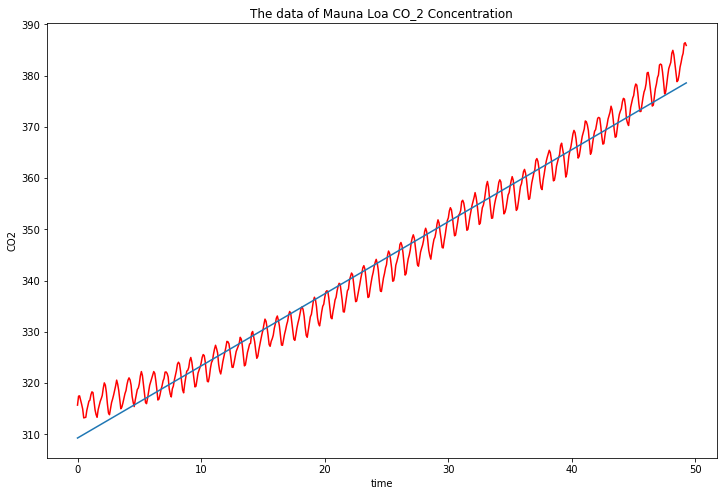

In [796]:
# plot the fitted model and the data 
plt.figure(figsize=(12,8))
plt.plot(X_train,y_train,c="r") # plot co2 value versus the time frame 
plt.plot(X_train,X_train*reg.coef_[0][0] + reg.intercept_[0]) # regression line 
plt.title("The data of Mauna Loa CO_2 Concentration")
plt.xlabel("time")
plt.ylabel("CO2")

### Question 2: Plot the residuals 
Plot the residual error 𝑅𝑙𝑖𝑛𝑒𝑎𝑟(𝑡)=𝐶(𝑡)−𝐹1(𝑡). 

Text(0, 0.5, 'residuals')

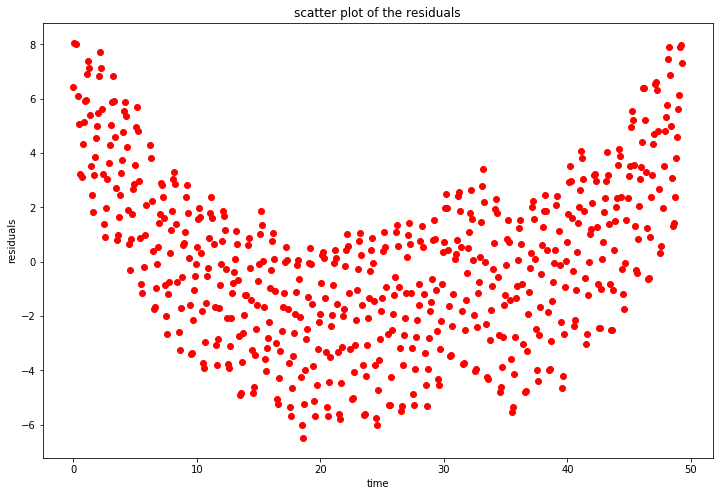

In [797]:
# scatter plot residuals 
plt.figure(figsize = (12,8))
plt.scatter(train_data['time'],residuals,c='r')
plt.title("scatter plot of the residuals")
plt.xlabel("time")
plt.ylabel("residuals")

### Question 3:
Plot the residual error 𝑅𝑙𝑖𝑛𝑒𝑎𝑟(𝑡)=𝐶(𝑡)−𝐹1(𝑡). Which of the following plots matches the residual plot generated?

In [798]:
# predict the new values for test values to find the RMSE and MAPE
preds = reg.predict(X_test)# predict the new CO2 values for X_test
print("the root mean squared error of the regression is {}".
      format(np.sqrt(mean_squared_error(y_test,preds)))) # mean squared error using sklearn.metrics
print("the mean absolute percentage error of the regression is {}".
      format(mean_absolute_percentage_error(y_test,preds))) # mean absolute percentage error using sklearn.metrics

the root mean squared error of the regression is 10.64207154566318
the mean absolute percentage error of the regression is 0.02450544085351372


### Fitting a Quadratic Model
In the problems below, we will fit quadratic and cubic models to the data and compute again RMSE and MAPE. We will then evaluate which of these models is the lowest degree model that still captures the trend of the data best sufficiently.

Now, fit the data to a quadratic model 𝐹2(𝑡)∼𝛽0+𝛽2𝑡+𝛽2𝑡2

### Question 4:

What are the values of 𝛽̂ 0, 𝛽̂ 1 and 𝛽̂ 2?

In [799]:
quad_reg = PolynomialFeatures(degree=2) # quadratic features 
X_poly = quad_reg.fit_transform(X_train) # fit and transform the train data to quadratic features
reg_2 = LinearRegression() # use linear regression 
reg_2.fit(X_poly, y_train) # fir the new features with the y_train 
print("quadratic regression gives the  parameters with B0 ({}) B1 ({})  B2 ({}) and intercept of {}".
      format(reg_2.coef_[0][0],reg_2.coef_[0][1],reg_2.coef_[0][2],reg_2.intercept_[0]))

quadratic regression gives the  parameters with B0 (0.0) B1 (0.8065007750451179)  B2 (0.012101193018091316) and intercept of 314.2662603158853


Text(0, 0.5, 'CO2')

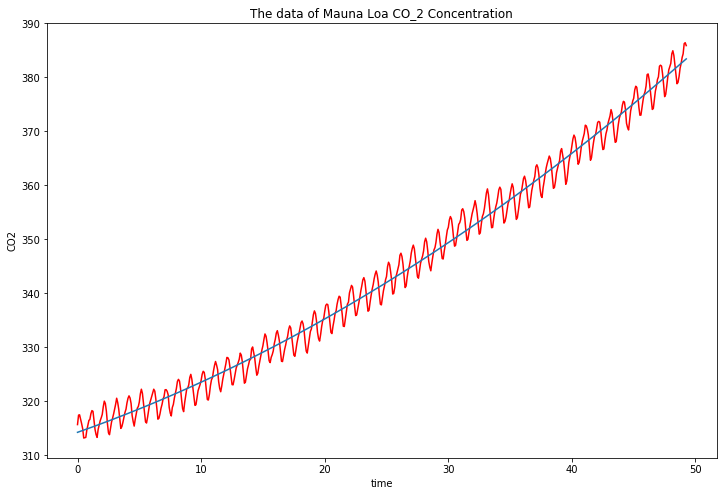

In [800]:
# plot the regression and data 
plt.figure(figsize=(12,8))
plt.plot(X_train,y_train,c="r") # plot co2 value versus the time frame 
plt.plot(X_train,np.dot(X_poly,reg_2.coef_[0].T) + reg_2.intercept_[0]) # quadratic regression fit 
plt.title("The data of Mauna Loa CO_2 Concentration")
plt.xlabel("time")
plt.ylabel("CO2")

### Question 5:
Plot the residual error 𝑅𝑞𝑢𝑎𝑑𝑟𝑎𝑡𝑖𝑐(𝑡)=𝐶(𝑡)−𝐹2(𝑡).

In [801]:
F_2 = np.dot(X_poly,reg_2.coef_[0].T) + reg_2.intercept_[0] # the regression function based on coefecients found 
quad_residuals = train_data['CO2'] - F_2 # the residuals based on formula  𝑅𝑞𝑢𝑎𝑑𝑟𝑎𝑡𝑖𝑐(𝑡)=𝐶(𝑡)−𝐹2(𝑡)

Text(0, 0.5, 'residuals')

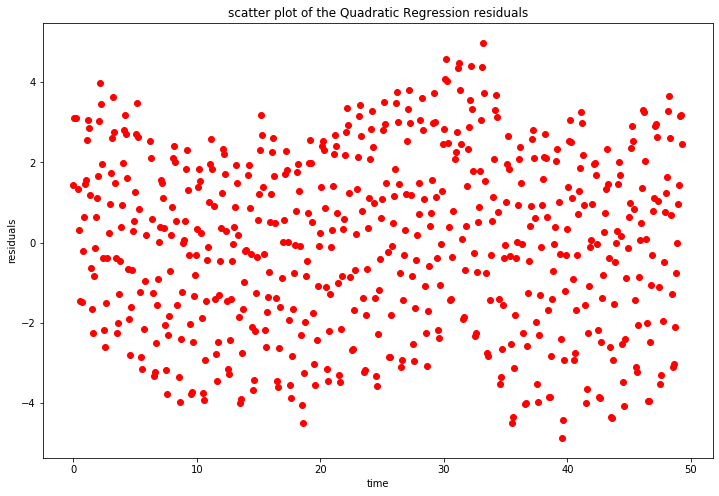

In [802]:
# scatter plot the residuals 
plt.figure(figsize = (12,8))
plt.scatter(train_data['time'],quad_residuals,c='r')
plt.title("scatter plot of the Quadratic Regression residuals")
plt.xlabel("time")
plt.ylabel("residuals")

In [803]:
# predict the new values for test values to find the RMSE and MAPE
preds = reg_2.predict(quad_reg.fit_transform(X_test))# predict the new CO2 values for X_test
print("the root mean squared error of the quadratic regression is {}".
      format(np.sqrt(mean_squared_error(y_test,preds)))) # mean squared error using sklearn.metrics
print("the mean absolute percentage error of the quadratic regression is {}".
      format(mean_absolute_percentage_error(y_test,preds))) # mean absolute percentage error using sklearn.metrics

the root mean squared error of the quadratic regression is 2.5028070716548383
the mean absolute percentage error of the quadratic regression is 0.0053228149626751795


### Fitting a Cubic Model

Now, fit the data to a cubic model 𝐹3(𝑡)∼𝛾1+𝛾2𝑡+𝛾2𝑡2+𝛾3𝑡3.


### Question 6:
What are the values of 𝛾̂ 0, 𝛾̂ 1, 𝛾̂ 2 and 𝛾̂ 3?

In [804]:
cubic_reg = PolynomialFeatures(degree=3) # Cubic features 
X_cubic = cubic_reg.fit_transform(X_train) # fit and transform the train data to Cubic features
reg_3 = LinearRegression() # use linear regression 
reg_3.fit(X_cubic, y_train) # fir the new features with the y_train 
print("quadratic regression gives the  parameters with 𝛾̂_0 ({}) 𝛾̂_1 ({})  𝛾̂_2 ({})  𝛾̂_3 ({}) and intercept of {}".
      format(reg_3.coef_[0][0],reg_3.coef_[0][1],reg_3.coef_[0][2],reg_3.coef_[0][3],reg_3.intercept_[0]))

quadratic regression gives the  parameters with 𝛾̂_0 (0.0) 𝛾̂_1 (0.6329122576715698)  𝛾̂_2 (0.020862686090740774)  𝛾̂_3 (-0.00011816736456482513) and intercept of 314.98865347446076


Text(0, 0.5, 'CO2')

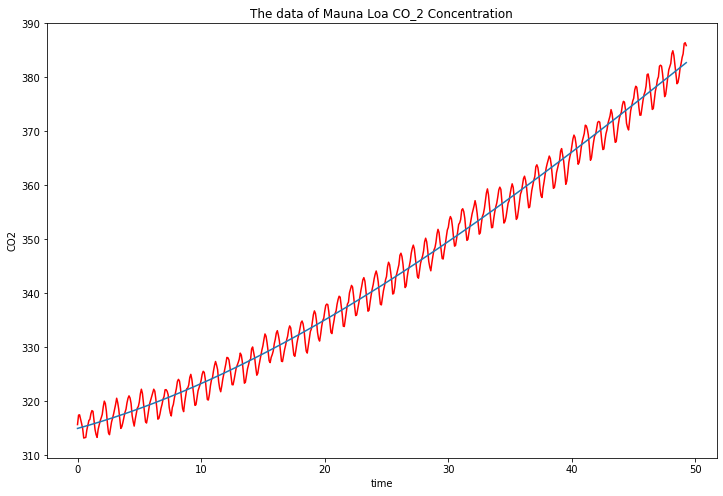

In [805]:
# plot the regression and data 
plt.figure(figsize=(12,8))
plt.plot(X_train,y_train,c="r") # plot co2 value versus the time frame 
plt.plot(X_train,np.dot(X_cubic,reg_3.coef_[0].T) + reg_3.intercept_[0]) # Cubic regression fit 
plt.title("The data of Mauna Loa CO_2 Concentration")
plt.xlabel("time")
plt.ylabel("CO2")

### Question 7:
Plot the residual error 𝑅𝑐𝑢𝑏𝑖𝑐

In [806]:
F_3 = np.dot(X_cubic,reg_3.coef_[0].T) + reg_3.intercept_[0] # the regression function based on coefecients found 
cubic_residuals = train_data['CO2'] - F_3 # the residuals based on formula  𝑅𝑞𝑢𝑎𝑑𝑟𝑎𝑡𝑖𝑐(𝑡)=𝐶(𝑡)−𝐹2(𝑡)

Text(0, 0.5, 'residuals')

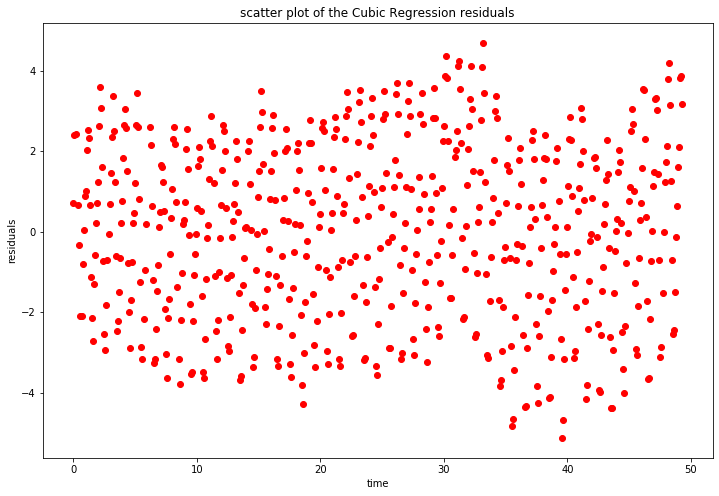

In [807]:
# scatter plot the residuals 
plt.figure(figsize = (12,8))
plt.scatter(train_data['time'],cubic_residuals,c='r')
plt.title("scatter plot of the Cubic Regression residuals")
plt.xlabel("time")
plt.ylabel("residuals")

### Question 8:
Report the root mean squared prediction error RMSE and the mean absolute percentage error MAPE with respect to the test set for this model.

In [808]:
# predict the new values for test values to find the RMSE and MAPE
preds = reg_3.predict(cubic_reg.fit_transform(X_test))# predict the new CO2 values for X_test
print("the root mean squared error of the Cubic regression is {}".
      format(np.sqrt(mean_squared_error(y_test,preds)))) # mean squared error using sklearn.metrics
print("the mean absolute percentage error of the Cubic regression is {}".
      format(mean_absolute_percentage_error(y_test,preds))) # mean absolute percentage error using sklearn.metrics

the root mean squared error of the Cubic regression is 4.151804435732791
the mean absolute percentage error of the Cubic regression is 0.008487820583308372


### Fitting a Periodic Signal

Consider 𝐹𝑛(𝑡) to be the polynomial trend chosen in the last problem as sufficient to represent the trend in the data. We will now extract the periodic component which appears in the data.

First, remove the deterministic trend 𝐹𝑛(𝑡) from the time series and compute the average residual 𝐶𝑖−𝐹𝑛(𝑡𝑖) for each month. Namely, collect all the residuals (from removing terministic trend) for Jan (resp. Feb, Mar, etc) and average them to get one data point for Jan (resp. Feb, Mar, etc). The collection of these points can be interpolated to form a periodic signal 𝑃𝑖. Report the values of the periodic signal 𝑃𝑖 for the month of January and February.



In [809]:
periodic_data = df.iloc[:587][["month","CO2","date"]] # define new data frame for periodic analysis
periodic_data['F_2'] = F_2 # add the column for the quadratic regression 
periodic_data['residuals'] =periodic_data['CO2'] - periodic_data['F_2'] # add residual column to remove trend term 
periodic_data.head() 

,month,CO2,date,F_2,residuals
4,3,315.70,1958-03-01,314.266260,1.433740
5,4,317.45,1958-04-01,314.334845,3.115155
6,5,317.51,1958-05-01,314.401383,3.108617
8,7,315.86,1958-07-01,314.537182,1.322818
9,8,314.93,1958-08-01,314.606454,0.323546


In [810]:
# average on the monthly residuals and get the seasonal value for each month from January to December 
seasonal_residuals = periodic_data.groupby("month").mean()
seasonal_residuals.head()

,CO2,F_2,residuals
month,,,
1,344.195714,344.211350,-0.015636
2,345.490417,344.848951,0.641465
3,345.691633,344.332448,1.359185
4,347.015510,344.452205,2.563305
5,347.057000,344.071011,2.985989


### Question 10:
What are the periodic signals for january and February

In [811]:
P_jan = seasonal_residuals['residuals'].iloc[0]
P_feb = seasonal_residuals['residuals'].iloc[1]
print("the Periodic signal for January is: ",P_jan)
print("the Periodic signal for February is: ",P_feb)

the Periodic signal for January is:  -0.015635517586664885
the Periodic signal for February is:  0.6414653232018566
